# Aligning to the rules of tic-tac-toe
****

Abstract:
***
Board games like tic-tac-toe and chess can be mathematically framed as two-player games, played in discrete time, with the Markov property (the information how the current state of the board was reached does not contain any more information than only the snapshot of the board). Humans learn how to play these games by understanding that the environment is a 3x3 (or 8x8) board, and the what the rules for a single move, as well as the winning conditions are. With this information we generate the directed graph of allowed steps $G = (V, E)$, where the vertices $V$ correspond to the possible states of the board and the edges $e = [v_1,v_2] \in E$ to a possible move between the state $v_1$ to the step $v_2$. Correct generation of this graph is equivalent to perfect understanding of the game, and can be used to align state of the art language models to play these games correctly. In this script I generate this graph from topological properties of the set of possible states of the board for the game of tic-tac-toe.

goal: Create a graph of possible moves from observations of allowed board states.

secondary goal: Use this knowledge graph to fine-tune an LLM (status quo: they can't do it)

restrictions: do not use 'moves' : changes from one state to another, or sequences of them. We can use them later for verification. sd


#Introduction: 

To frame this work in a setting which might be usable for the highest level of automation of this algorithm, let us assume that for training we have a complete set of the states of the board which were generated in a process that adhered to the rules of the game. To frame this precisely, let us denote this dataset $\mathcal{X}$. $x = [x_0, \ldots, x_8] \in \mathcal{X}$ if and only if there exists a sequence of moves of the two players such that no rules were violated. We use any enumeration of the tiles of the board, for instance:
$$
0|1|2\\
---\\
3|4|5\\
---\\
6|7|8\\
---
$$
and represent the state of the board numerically: 
$$ x_i = \begin{cases} 
0, & \text{if the tile is empty} \\
1, & \text{if there is an X in the i-th tile} \\
-1, & \text{if there is an O in the i-th tile} 
\end{cases} $$


In the code below I generate such a dataset by simulationg such games, and apply Topological Data Analysis methods as a way to capture the property of a game that two consequent states of the game should lie in close proximity of one another. For a complicated game, such as chess, one aims to learn a feature map $ \Phi : \mathbf{R} ^{64} \rightarrow Y$ which will capture the features of the game more accurately than the identity map, and only then apply a metric to measure proximity of two states. The goal of this is feature map is to capture the rules governing the moves of a bishop or a knight figure, and I believe the way to do this is to apply self supervised learning methods. The notion of proximity after applying such a feature map is just a canonical filtration for a value $\epsilon > 0$: $[v_1, v_2] \in E \iff ||v_1 - v_2 || < \epsilon $. The choice of the value of $\epsilon$ will be heuristically taken as the value for which the largest number of homology classes of dimension one exist. 

This is heuristically dictatd by the following observation: For states of the board $x_1, x_2 \in \mathcal{X}$, which lie two moves apart, there exist two intermediate states $ y , z \in \mathcal{X} $ such that the edges: $ [x_1, y], [y, x_2] , [x_1, z], [z, x_2] \in E$, but $[x_1, x_2] , [y,z] \notin E$. This property of two player games occours because the edges $ [x_1, y] , [z,x_2]$ can be explained by moves of the 'X' player, such as placing an X in the $x_3$ tile, whereas the edges $[x_1, z], [y,x_2]$ correspond to the moves of the 'O' player, for instance placing an O on the $x_1$ tile. We assume that the dataset was generated from both 'O - first' games and 'X - first' games, and this is why such sets of four edges will appear. Equally important as the edges that appear in the graph are the ones that do not - we notice that in the $l_1$ (or $l_2$) metrics, the states $y, z$ will be distance $2$ (or $\sqrt{2}$) apart, so a filtration value $\epsilon \in (1, 2)$, (or $(1, \sqrt{2})$ ) will capture exactly the right edges for the game of tic-tac-toe. 

Below is the experimental verification of these hypotheses.



___
explanation why  the homology classes of dimesnion 1 matter:

In [ ]:

.|.|.            .|.|.
- - -            _ _ _ 
.|.|.    - - - > X|.|.
- - -            - - - 
.|.|.            .|.|. 
    \                \
     \                \
      \                \
       >                >
       .|O|.            .|0|.
       - - -            _ _ _ 
       .|.|.    - - - > X|.|.
       - - -            - - - 
       .|.|.            .|.|.



In the diagram above I illustrate the example of two sequences of moves that begin and end in the same states. We notice, that

In [3]:
import copy
import random
import numpy as np
from ripser import ripser
import matplotlib.pyplot as plt
from persim import plot_diagrams


def initialize_board():
    return [[' ' for _ in range(3)] for _ in range(3)]

def print_board(board):
    for row in board:
        print('|'.join(row))
        print('-' * 5)

def check_winner(board):
    # Check rows
    for row in board:
        if row[0] == row[1] == row[2] != ' ':
            return row[0]

    # Check columns
    for col in range(3):
        if board[0][col] == board[1][col] == board[2][col] != ' ':
            return board[0][col]

    # Check diagonals
    if board[0][0] == board[1][1] == board[2][2] != ' ':
        return board[0][0]
    if board[0][2] == board[1][1] == board[2][0] != ' ':
        return board[0][2]

    return None

def simulate_game():
    board = initialize_board()
    moves = 0
    players = ['X', 'O']
    random.shuffle(players)
    current_player = players[0]
    game_steps = []

    while moves < 9:
        row = random.randint(0, 2)
        col = random.randint(0, 2)
        if board[row][col] == ' ':
            board[row][col] = current_player
            game_steps.append(copy.deepcopy(board))
            winner = check_winner(board)
            if winner:
                return game_steps, winner
            moves += 1
            current_player = players[moves % 2]

    return game_steps, 'Draw'

def generate_simulations(n):
    simulations = []
    for _ in range(n):
        game_steps, winner = simulate_game()
        simulations.append((game_steps, winner))
    return simulations

n = 10000
simulations = generate_simulations(n)


Below we change the representation of the states of the board to a vector, eliminate duplicates, and shuffle it.

In [12]:
def board_to_vector(board):
    vector = []
    for row in board:
        for cell in row:
            if cell == 'X':
                vector.append(1)
            elif cell == 'O':
                vector.append(-1)
            else:
                vector.append(0)
    return vector


def simulations_to_vectors(simulations):
    vector_simulations = []
    for game_steps, winner in simulations:
        #game_vectors = []
        for board in game_steps:
            vector_simulations.append(board_to_vector(board))
        #vector_simulations.append((game_vectors, winner))
    return vector_simulations


#
# Convert simulations to vector representations
vector_simulations = simulations_to_vectors(simulations)

#remove the duplicates from the vector simulation. Ripler will treat them as different points and work itself to death
print(len(vector_simulations))
#my_list = [[1, 2], [3, 4], [1, 2], [5, 6], [3, 4]]
unique_list = [list(t) for t in set(tuple(element) for element in vector_simulations)]
vector_simulations = unique_list
print(len(vector_simulations))

'''
# Example usage
for i, (game_vectors, winner) in enumerate(vector_simulations, 1):
    print(f"Simulation {i}:")
    print("Winner:", winner)
    print("Game Vectors:")
    for step, vector in enumerate(game_vectors):
        print(f"Step {step + 1}: {vector}")
    print()
''' 
#print(vector_simulations , "\n\n\n\n")
random.shuffle(vector_simulations)
#print(vector_simulations)


76307
8403


That's the heavy-lifting, done by Persistent Homology. Classes in $H_0$ correspond to connected components, in $H_1$ to loops in the graph - sequences of two moves which begin and end at two distinct states.

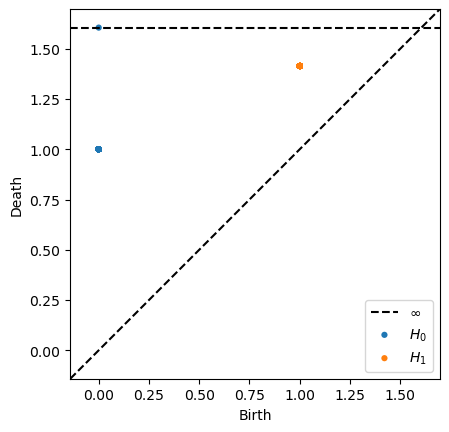

In [13]:

# Assuming my_vector is a list of vectors in R^9


# Convert the list of vectors to a numpy array
point_cloud = np.array(vector_simulations)



# Compute the persistent homology
diagrams = ripser(point_cloud)['dgms']
plot_diagrams(diagrams, show=True)


In [14]:
for dim, diagram in enumerate(diagrams):
    print(f"Dimension {dim}:")
    for i, (birth, death) in enumerate(diagram):
        print(f"Homology Class {i}: Birth: {birth}, Death: {death}")



Dimension 0:
Homology Class 0: Birth: 0.0, Death: 1.0
Homology Class 1: Birth: 0.0, Death: 1.0
Homology Class 2: Birth: 0.0, Death: 1.0
Homology Class 3: Birth: 0.0, Death: 1.0
Homology Class 4: Birth: 0.0, Death: 1.0
Homology Class 5: Birth: 0.0, Death: 1.0
Homology Class 6: Birth: 0.0, Death: 1.0
Homology Class 7: Birth: 0.0, Death: 1.0
Homology Class 8: Birth: 0.0, Death: 1.0
Homology Class 9: Birth: 0.0, Death: 1.0
Homology Class 10: Birth: 0.0, Death: 1.0
Homology Class 11: Birth: 0.0, Death: 1.0
Homology Class 12: Birth: 0.0, Death: 1.0
Homology Class 13: Birth: 0.0, Death: 1.0
Homology Class 14: Birth: 0.0, Death: 1.0
Homology Class 15: Birth: 0.0, Death: 1.0
Homology Class 16: Birth: 0.0, Death: 1.0
Homology Class 17: Birth: 0.0, Death: 1.0
Homology Class 18: Birth: 0.0, Death: 1.0
Homology Class 19: Birth: 0.0, Death: 1.0
Homology Class 20: Birth: 0.0, Death: 1.0
Homology Class 21: Birth: 0.0, Death: 1.0
Homology Class 22: Birth: 0.0, Death: 1.0
Homology Class 23: Birth: 0.0, 

We now create a graph for a filtration value which corresponds to the largest number of the $H_1$ classes. 

In this case, between 1 and 1.41, so $\sqrt{2}$

In [32]:
import networkx as nx
from itertools import combinations

def distance(point1, point2):
    return np.linalg.norm(np.array(point1) - np.array(point2), ord = 1)

def create_graph(points, r):
    G = nx.Graph()
    for i, point in enumerate(points):
        G.add_node(i, pos=tuple(point))
    
    for (i, point1), (j, point2) in combinations(enumerate(points), 2):   # <- this part is in (nr_states)^2, so even for tic-tac-toe it takes a while
        if distance(point1, point2) <= r:
            G.add_edge(i, j)
    
    return G


r = 1.3

# Create the graph
G = create_graph(vector_simulations, r)



In [34]:

def points_within_k_edges(G, node, k):
    visited = set()
    queue = [(node, 0)]
    points_within_k = set()

    while queue:
        current_node, depth = queue.pop(0)
        if depth < k:
            for neighbor in G.neighbors(current_node):
                if neighbor not in visited:
                    queue.append((neighbor, depth + 1))
                    points_within_k.add(neighbor)
            visited.add(current_node)
    
    return points_within_k

# Input node
input_node = 0

# Print points within 2 edges of the input node
points_within_2_edges = points_within_k_edges(G, input_node, 2)
print("Points within 2 edges of node", input_node, ":")
for node in points_within_2_edges:
    print("Node:", node, "Position:", G.nodes[node]['pos'])


Points within 2 edges of node 0 :
Node: 5761 Position: (0, 1, 0, 1, -1, -1, 0, 1, -1)
Node: 1154 Position: (0, 0, 0, 1, 0, -1, -1, 1, -1)
Node: 5122 Position: (0, 1, -1, 1, 0, -1, 0, 1, -1)
Node: 8194 Position: (0, 1, -1, 1, 0, 0, -1, 1, -1)
Node: 7681 Position: (0, 1, 0, 1, 0, -1, -1, 0, 0)
Node: 3211 Position: (0, 1, 0, 1, 0, -1, -1, 1, 0)
Node: 6418 Position: (0, 1, 1, 1, -1, -1, -1, 1, -1)
Node: 6803 Position: (1, 1, 0, 1, 0, -1, -1, 0, -1)
Node: 4501 Position: (1, 1, 0, 1, 0, -1, -1, 1, -1)
Node: 5654 Position: (-1, 1, 0, 1, 0, 0, -1, 1, -1)
Node: 7836 Position: (0, 0, 0, 1, 1, -1, -1, 1, -1)
Node: 7076 Position: (-1, 1, 0, 1, 0, -1, -1, 1, -1)
Node: 7333 Position: (1, 0, 0, 1, 0, -1, -1, 1, -1)
Node: 6439 Position: (0, 0, 1, 1, 0, -1, -1, 1, -1)
Node: 2471 Position: (0, 1, 1, 0, 0, -1, -1, 1, -1)
Node: 8105 Position: (0, 1, 0, 1, 0, 0, -1, 1, -1)
Node: 6313 Position: (0, 1, 0, 1, -1, -1, -1, 1, 0)
Node: 2731 Position: (0, 1, 0, 1, 0, -1, -1, 0, -1)
Node: 1836 Position: (0, 1, -1,

In [35]:
G.nodes[input_node]['pos']


def print_tic_tac_toe_board(G, node):
    position = G.nodes[node]['pos']
    board = [[' ' for _ in range(3)] for _ in range(3)]
    for i, pos in enumerate(position):
        row = i // 3
        col = i % 3
        if pos == 1:
            board[row][col] = 'X'
        elif pos == -1:
            board[row][col] = 'O'
    for row in board:
        print('|'.join(row))
        print('-' * 5)

# Example usage
# Assuming G is the graph of Tic Tac Toe states
node = 0  # Example node in the graph
print("Tic Tac Toe board corresponding to node", node)
print_tic_tac_toe_board(G, node)





Tic Tac Toe board corresponding to node 0
 |X| 
-----
X| |O
-----
O|X|O
-----


In [37]:
print("start:")
print_tic_tac_toe_board(G, input_node)


points_within_1_edge = points_within_k_edges(G, input_node, 1)
print("Points within 1 edge of node", input_node, ":")
for node in points_within_1_edge:
    print("Node:", node, "Position:", G.nodes[node]['pos'])
    print(print_tic_tac_toe_board(G, node))

start:
 |X| 
-----
X| |O
-----
O|X|O
-----
Points within 1 edge of node 0 :
Node: 1154 Position: (0, 0, 0, 1, 0, -1, -1, 1, -1)
 | | 
-----
X| |O
-----
O|X|O
-----
None
Node: 7076 Position: (-1, 1, 0, 1, 0, -1, -1, 1, -1)
O|X| 
-----
X| |O
-----
O|X|O
-----
None
Node: 8105 Position: (0, 1, 0, 1, 0, 0, -1, 1, -1)
 |X| 
-----
X| | 
-----
O|X|O
-----
None
Node: 1227 Position: (0, 1, 0, 1, 0, -1, 0, 1, -1)
 |X| 
-----
X| |O
-----
 |X|O
-----
None
Node: 1836 Position: (0, 1, -1, 1, 0, -1, -1, 1, -1)
 |X|O
-----
X| |O
-----
O|X|O
-----
None
Node: 2731 Position: (0, 1, 0, 1, 0, -1, -1, 0, -1)
 |X| 
-----
X| |O
-----
O| |O
-----
None
Node: 3211 Position: (0, 1, 0, 1, 0, -1, -1, 1, 0)
 |X| 
-----
X| |O
-----
O|X| 
-----
None
Node: 4501 Position: (1, 1, 0, 1, 0, -1, -1, 1, -1)
X|X| 
-----
X| |O
-----
O|X|O
-----
None
Node: 119 Position: (0, 1, 0, 1, 1, -1, -1, 1, -1)
 |X| 
-----
X|X|O
-----
O|X|O
-----
None
Node: 2745 Position: (0, 1, 0, 0, 0, -1, -1, 1, -1)
 |X| 
-----
 | |O
-----
O|X|O
-----
N